# CODI Model vs NLP Chain-of-Thought Comparison

This notebook demonstrates:
1. **CODI Model**: Compresses chain-of-thought into latent continuous space
2. **NLP-based Model**: Standard model with explicit natural language chain-of-thought

We'll extract hidden activations and latent/NLP traces from both.

In [1]:
import sys
sys.path.insert(0, 'codi')

import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, TaskType, get_peft_model
from huggingface_hub import hf_hub_download
import os

from src.model import CODI, ModelArguments, TrainingArguments

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Setup: Download CODI checkpoint and configure models

In [2]:
# Download CODI-gpt2 checkpoint from HuggingFace
ckpt_dir = "codi_gpt2_ckpt"
os.makedirs(ckpt_dir, exist_ok=True)

try:
    ckpt_path = hf_hub_download(
        repo_id="zen-E/CODI-gpt2",
        filename="pytorch_model.bin",
        local_dir=ckpt_dir
    )
    print(f"Downloaded checkpoint to: {ckpt_path}")
except Exception as e:
    print(f"Could not download checkpoint: {e}")
    print("Will use randomly initialized model for demonstration")
    ckpt_path = None

Downloaded checkpoint to: codi_gpt2_ckpt/pytorch_model.bin


In [3]:
# Configure model arguments
model_args = ModelArguments(
    model_name_or_path="gpt2",
    lora_r=128,
    lora_alpha=32,
    lora_init=True,
    train=False,
)

# Create a minimal training args for model initialization
class MinimalTrainingArgs:
    bf16 = True
    num_latent = 6
    use_lora = True
    use_prj = True
    prj_dim = 768
    prj_dropout = 0.0
    prj_no_ln = False
    restore_from = ""
    inf_latent_iterations = 6
    remove_eos = True
    fix_attn_mask = False
    print_loss = False
    distill_loss_div_std = False
    distill_loss_type = "smooth_l1"
    distill_loss_factor = 1.0
    ref_loss_factor = 1.0

training_args = MinimalTrainingArgs()

## Load CODI Model (Latent Thought Model)

In [4]:
# Create LoRA config
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=True,
    r=model_args.lora_r,
    lora_alpha=model_args.lora_alpha,
    lora_dropout=0.1,
    target_modules=["c_attn", "c_proj", "c_fc"],
    init_lora_weights=True,
)

# Initialize CODI model
codi_model = CODI(model_args, training_args, lora_config)

# Load checkpoint if available
if ckpt_path and os.path.exists(ckpt_path):
    state_dict = torch.load(ckpt_path, map_location=device)
    
    # Diagnose key matching
    model_keys = set(codi_model.state_dict().keys())
    ckpt_keys = set(state_dict.keys())
    print(f"Checkpoint keys (first 5): {sorted(ckpt_keys)[:5]}")
    print(f"Model keys (first 5): {sorted(model_keys)[:5]}")
    print(f"Matching keys: {len(model_keys & ckpt_keys)}/{len(ckpt_keys)}")
    
    result = codi_model.load_state_dict(state_dict, strict=False)
    print(f"Missing keys: {len(result.missing_keys)}")
    print(f"Unexpected keys: {len(result.unexpected_keys)}")
    if result.unexpected_keys:
        print(f"Unexpected (first 5): {result.unexpected_keys[:5]}")
    if result.missing_keys:
        print(f"Missing (first 5): {result.missing_keys[:5]}")
    print("Loaded CODI checkpoint")
else:
    print("Using randomly initialized CODI model")

codi_model = codi_model.to(device=device, dtype=torch.bfloat16)
codi_model.eval()
print(f"CODI model loaded on {device}")

/nfs/nhome/live/jbauer/venvs/ml/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/nfs/nhome/live/jbauer/venvs/ml/lib/python3.12/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Checkpoint keys (first 5): ['codi.base_model.model.lm_head.weight', 'codi.base_model.model.transformer.h.0.attn.c_attn.base_layer.bias', 'codi.base_model.model.transformer.h.0.attn.c_attn.base_layer.weight', 'codi.base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight', 'codi.base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight']
Model keys (first 5): ['codi.base_model.model.lm_head.weight', 'codi.base_model.model.transformer.h.0.attn.c_attn.base_layer.bias', 'codi.base_model.model.transformer.h.0.attn.c_attn.base_layer.weight', 'codi.base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight', 'codi.base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight']
Matching keys: 251/251
Missing keys: 0
Unexpected keys: 0
Loaded CODI checkpoint
CODI model loaded on cuda


## Load NLP-based Model (Explicit Chain-of-Thought)

The NLP cousin uses the same base GPT-2 but processes explicit natural language chain-of-thought instead of latent thoughts.

In [5]:
# Load base GPT-2 for NLP chain-of-thought (no latent compression)
nlp_model = AutoModelForCausalLM.from_pretrained(
    "gpt2",
    torch_dtype=torch.bfloat16 if training_args.bf16 else torch.float32,
)
nlp_tokenizer = AutoTokenizer.from_pretrained("gpt2")
nlp_tokenizer.pad_token = nlp_tokenizer.eos_token

nlp_model = nlp_model.to(device)
nlp_model.eval()
print(f"NLP model loaded on {device}")

NLP model loaded on cuda


## Define Query and Helper Functions

In [6]:
# Sample math query (GSM8K style)
query = "Janet's ducks lay 16 eggs per day. She eats three for breakfast every morning. How many eggs does she have left each day?"

# Chain-of-thought prompt for NLP model
cot_prompt = f"""Question: {query}

Let me solve this step by step:
Step 1: Janet's ducks lay 16 eggs per day.
Step 2: She eats 3 eggs for breakfast.
Step 3: Eggs left = 16 - 3 = 13

The answer is 13."""

print("Query:", query)
print("\nCoT Prompt for NLP model:")
print(cot_prompt)

Query: Janet's ducks lay 16 eggs per day. She eats three for breakfast every morning. How many eggs does she have left each day?

CoT Prompt for NLP model:
Question: Janet's ducks lay 16 eggs per day. She eats three for breakfast every morning. How many eggs does she have left each day?

Let me solve this step by step:
Step 1: Janet's ducks lay 16 eggs per day.
Step 2: She eats 3 eggs for breakfast.
Step 3: Eggs left = 16 - 3 = 13

The answer is 13.


In [7]:
def extract_hidden_states_summary(hidden_states):
    """Extract summary statistics from hidden states."""
    summary = {
        "num_layers": len(hidden_states),
        "shape_per_layer": hidden_states[0].shape,
        "last_layer_mean": hidden_states[-1].mean().item(),
        "last_layer_std": hidden_states[-1].std().item(),
        "last_token_embedding": hidden_states[-1][:, -1, :].detach().cpu(),
    }
    return summary

def decode_latent_to_tokens(model, latent_embd, tokenizer, top_k=5):
    """Probe what tokens the latent embedding represents."""
    with torch.no_grad():
        # Get logits by passing through lm_head
        if hasattr(model, 'codi'):
            logits = model.codi.lm_head(latent_embd)
        else:
            logits = model.lm_head(latent_embd)
        probs = torch.softmax(logits, dim=-1)
        top_probs, top_indices = torch.topk(probs, k=top_k, dim=-1)
        
        decoded = []
        for i in range(top_indices.shape[1]):
            tokens = [tokenizer.decode([idx.item()]) for idx in top_indices[0, i]]
            probs_list = top_probs[0, i].tolist()
            decoded.append(list(zip(tokens, probs_list)))
    return decoded

## Run CODI Model: Extract Latent Traces and Hidden Activations

In [8]:
# Tokenize input for CODI
codi_tokenizer = codi_model.tokenizer
inputs = codi_tokenizer(query, return_tensors="pt").to(device)

# Add BOT (beginning of thought) token
if training_args.remove_eos:
    bot_tensor = torch.tensor([[codi_model.bot_id]], dtype=torch.long, device=device)
else:
    bot_tensor = torch.tensor([[codi_tokenizer.eos_token_id, codi_model.bot_id]], dtype=torch.long, device=device)

input_ids = torch.cat([inputs["input_ids"], bot_tensor], dim=1)
attention_mask = torch.cat([inputs["attention_mask"], torch.ones_like(bot_tensor)], dim=1)

print(f"Input tokens: {codi_tokenizer.decode(inputs['input_ids'][0])} [BOT]")
print(f"Input shape: {input_ids.shape}")

Input tokens: Janet's ducks lay 16 eggs per day. She eats three for breakfast every morning. How many eggs does she have left each day? [BOT]
Input shape: torch.Size([1, 29])


In [9]:
# Run CODI model and collect latent traces
codi_latent_traces = []
codi_hidden_activations = []
codi_decoded_latents = []

with torch.no_grad():
    # Initial encoding
    outputs = codi_model.codi(
        input_ids=input_ids,
        attention_mask=attention_mask,
        use_cache=True,
        output_hidden_states=True
    )
    past_key_values = outputs.past_key_values
    
    # Extract initial hidden state (last token = BOT position)
    latent_embd = outputs.hidden_states[-1][:, -1, :].unsqueeze(1)
    codi_latent_traces.append(latent_embd.clone())
    codi_hidden_activations.append(extract_hidden_states_summary(outputs.hidden_states))
    codi_decoded_latents.append(decode_latent_to_tokens(codi_model, latent_embd, codi_tokenizer))
    
    # Apply projection if used
    if training_args.use_prj:
        latent_embd = codi_model.prj(latent_embd)
    
    # Iterate through latent thought steps
    for i in range(training_args.inf_latent_iterations):
        outputs = codi_model.codi(
            inputs_embeds=latent_embd,
            use_cache=True,
            output_hidden_states=True,
            past_key_values=past_key_values
        )
        past_key_values = outputs.past_key_values
        latent_embd = outputs.hidden_states[-1][:, -1, :].unsqueeze(1)
        
        # Store traces before projection
        codi_latent_traces.append(latent_embd.clone())
        codi_hidden_activations.append(extract_hidden_states_summary(outputs.hidden_states))
        codi_decoded_latents.append(decode_latent_to_tokens(codi_model, latent_embd, codi_tokenizer))
        
        if training_args.use_prj:
            latent_embd = codi_model.prj(latent_embd)

print(f"Collected {len(codi_latent_traces)} latent traces")
print(f"Latent embedding shape: {codi_latent_traces[0].shape}")

Collected 7 latent traces
Latent embedding shape: torch.Size([1, 1, 768])


In [10]:
# Display CODI latent traces (decoded to most likely tokens)
print("=" * 60)
print("CODI LATENT TRACES (Decoded to top-5 tokens)")
print("=" * 60)

for i, decoded in enumerate(codi_decoded_latents):
    step_name = "Initial (BOT)" if i == 0 else f"Latent Step {i}"
    print(f"\n{step_name}:")
    print(f"  Top tokens: {decoded[0][:5]}")

CODI LATENT TRACES (Decoded to top-5 tokens)

Initial (BOT):
  Top tokens: [('The', 0.10595703125), ('\n', 0.060302734375), (' the', 0.0322265625), ('the', 0.0184326171875), ('3', 0.017333984375)]

Latent Step 1:
  Top tokens: [('?', 0.51171875), ('The', 0.310546875), (' The', 0.0693359375), (' is', 0.0255126953125), ('\n', 0.0224609375)]

Latent Step 2:
  Top tokens: [('3', 0.1376953125), ('each', 0.1123046875), ('\n', 0.08740234375), (' each', 0.06787109375), ('1', 0.0311279296875)]

Latent Step 3:
  Top tokens: [(' is', 0.51953125), ('?', 0.24609375), ('The', 0.056640625), ('Story', 0.021484375), ('\n', 0.017333984375)]

Latent Step 4:
  Top tokens: [('\n', 0.107421875), (' is', 0.07373046875), ('Story', 0.04931640625), (' each', 0.046142578125), ('The', 0.046142578125)]

Latent Step 5:
  Top tokens: [(' is', 0.859375), ('is', 0.025146484375), ('?', 0.0244140625), (' isn', 0.0167236328125), ('The', 0.0157470703125)]

Latent Step 6:
  Top tokens: [(' is', 0.87109375), ('is', 0.022460

In [11]:
# Display CODI hidden activation statistics
print("=" * 60)
print("CODI HIDDEN ACTIVATIONS")
print("=" * 60)

for i, activation in enumerate(codi_hidden_activations):
    step_name = "Initial" if i == 0 else f"Latent Step {i}"
    print(f"\n{step_name}:")
    print(f"  Num layers: {activation['num_layers']}")
    print(f"  Last layer mean: {activation['last_layer_mean']:.4f}")
    print(f"  Last layer std: {activation['last_layer_std']:.4f}")
    print(f"  Last token embedding norm: {activation['last_token_embedding'].norm().item():.4f}")

CODI HIDDEN ACTIVATIONS

Initial:
  Num layers: 13
  Last layer mean: 0.1309
  Last layer std: 5.2812
  Last token embedding norm: 34.0000

Latent Step 1:
  Num layers: 13
  Last layer mean: 0.1064
  Last layer std: 2.3438
  Last token embedding norm: 65.0000

Latent Step 2:
  Num layers: 13
  Last layer mean: 0.0422
  Last layer std: 1.3828
  Last token embedding norm: 38.2500

Latent Step 3:
  Num layers: 13
  Last layer mean: 0.0630
  Last layer std: 1.4922
  Last token embedding norm: 41.5000

Latent Step 4:
  Num layers: 13
  Last layer mean: 0.0684
  Last layer std: 1.5312
  Last token embedding norm: 42.5000

Latent Step 5:
  Num layers: 13
  Last layer mean: 0.0845
  Last layer std: 1.6719
  Last token embedding norm: 46.5000

Latent Step 6:
  Num layers: 13
  Last layer mean: 0.0840
  Last layer std: 1.7109
  Last token embedding norm: 47.5000


## Run NLP Model: Extract Chain-of-Thought Traces and Hidden Activations

In [12]:
# Tokenize CoT prompt for NLP model
nlp_inputs = nlp_tokenizer(cot_prompt, return_tensors="pt").to(device)

print(f"NLP input length: {nlp_inputs['input_ids'].shape[1]} tokens")

NLP input length: 82 tokens


In [13]:
# Run NLP model with explicit CoT
with torch.no_grad():
    nlp_outputs = nlp_model(
        input_ids=nlp_inputs["input_ids"],
        attention_mask=nlp_inputs["attention_mask"],
        output_hidden_states=True
    )

nlp_hidden_summary = extract_hidden_states_summary(nlp_outputs.hidden_states)
print(f"NLP model hidden states collected")
print(f"  Num layers: {nlp_hidden_summary['num_layers']}")
print(f"  Shape per layer: {nlp_hidden_summary['shape_per_layer']}")

NLP model hidden states collected
  Num layers: 13
  Shape per layer: torch.Size([1, 82, 768])


In [14]:
# Extract NLP traces at key positions (each CoT step)
cot_steps = [
    "Question:",
    "Step 1:",
    "Step 2:",
    "Step 3:",
    "The answer is"
]

nlp_traces = []
tokens = nlp_tokenizer.encode(cot_prompt)

print("=" * 60)
print("NLP CHAIN-OF-THOUGHT TRACES")
print("=" * 60)

for step in cot_steps:
    # Find position of this step in the tokenized input
    step_tokens = nlp_tokenizer.encode(step, add_special_tokens=False)
    
    # Search for the step in the token sequence
    for pos in range(len(tokens) - len(step_tokens) + 1):
        if tokens[pos:pos+len(step_tokens)] == step_tokens:
            # Get hidden state at this position
            hidden = nlp_outputs.hidden_states[-1][0, pos + len(step_tokens) - 1, :]
            nlp_traces.append({
                "step": step,
                "position": pos,
                "hidden_norm": hidden.norm().item(),
                "hidden_mean": hidden.mean().item(),
                "hidden_std": hidden.std().item(),
                "embedding": hidden.cpu()
            })
            print(f"\n{step} (position {pos}):")
            print(f"  Hidden norm: {hidden.norm().item():.4f}")
            print(f"  Hidden mean: {hidden.mean().item():.4f}")
            print(f"  Hidden std: {hidden.std().item():.4f}")
            break

NLP CHAIN-OF-THOUGHT TRACES

Question: (position 0):
  Hidden norm: 270.0000
  Hidden mean: 0.4805
  Hidden std: 9.7500

Step 1: (position 40):
  Hidden norm: 314.0000
  Hidden mean: 0.5547
  Hidden std: 11.3125

Step 2: (position 53):
  Hidden norm: 296.0000
  Hidden mean: 0.5273
  Hidden std: 10.6875

Step 3: (position 64):
  Hidden norm: 308.0000
  Hidden mean: 0.5625
  Hidden std: 11.0625

The answer is (position 77):
  Hidden norm: 296.0000
  Hidden mean: 0.4609
  Hidden std: 10.6875


## Compare CODI vs NLP Hidden Activations

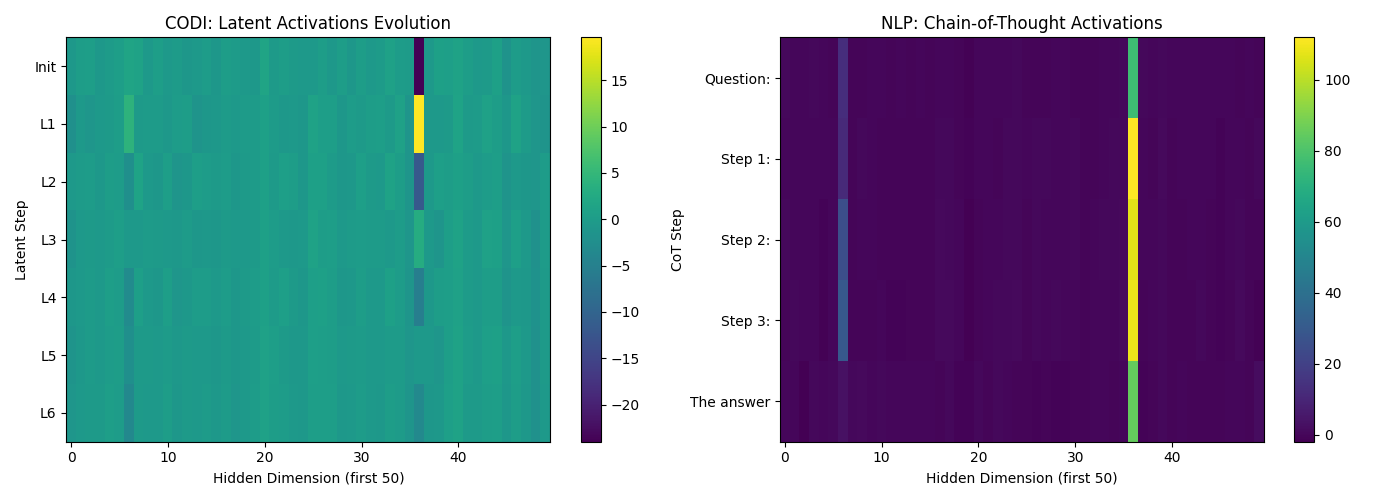

In [20]:
# Visualize hidden state evolution
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CODI hidden states (first 50 dimensions)
codi_hidden_matrix = torch.stack([t.squeeze() for t in codi_latent_traces]).cpu().float().numpy()
im1 = axes[0].imshow(codi_hidden_matrix[:, :50], aspect='auto', cmap='viridis')
axes[0].set_xlabel('Hidden Dimension (first 50)')
axes[0].set_ylabel('Latent Step')
axes[0].set_title('CODI: Latent Activations Evolution')
axes[0].set_yticks(range(len(codi_latent_traces)))
axes[0].set_yticklabels(['Init'] + [f'L{i+1}' for i in range(len(codi_latent_traces)-1)])
plt.colorbar(im1, ax=axes[0])

# NLP hidden states at CoT positions
if nlp_traces:
    nlp_hidden_matrix = torch.stack([t['embedding'] for t in nlp_traces]).float().numpy()
    im2 = axes[1].imshow(nlp_hidden_matrix[:, :50], aspect='auto', cmap='viridis')
    axes[1].set_xlabel('Hidden Dimension (first 50)')
    axes[1].set_ylabel('CoT Step')
    axes[1].set_title('NLP: Chain-of-Thought Activations')
    axes[1].set_yticks(range(len(nlp_traces)))
    axes[1].set_yticklabels([t['step'][:10] for t in nlp_traces])
    plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

In [21]:
# Summary of all collected data
print("=" * 60)
print("SUMMARY: Available Data")
print("=" * 60)

print("\n1. CODI Latent Traces:")
print(f"   - Number of traces: {len(codi_latent_traces)}")
print(f"   - Shape per trace: {codi_latent_traces[0].shape}")
print(f"   - Access: codi_latent_traces[i] for raw tensor")

print("\n2. CODI Hidden Activations:")
print(f"   - Number of snapshots: {len(codi_hidden_activations)}")
print(f"   - Layers per snapshot: {codi_hidden_activations[0]['num_layers']}")
print(f"   - Access: codi_hidden_activations[i]['last_token_embedding']")

print("\n3. CODI Decoded Latents (token interpretations):")
print(f"   - Access: codi_decoded_latents[i] for top-k tokens")

print("\n4. NLP Chain-of-Thought Traces:")
print(f"   - Number of CoT steps captured: {len(nlp_traces)}")
print(f"   - Access: nlp_traces[i]['embedding'] for hidden state")
print(f"   - Access: nlp_traces[i]['step'] for step name")

print("\n5. Full NLP Hidden States:")
print(f"   - Access: nlp_outputs.hidden_states for all layers")
print(f"   - Shape: {nlp_outputs.hidden_states[-1].shape}")

SUMMARY: Available Data

1. CODI Latent Traces:
   - Number of traces: 7
   - Shape per trace: torch.Size([1, 1, 768])
   - Access: codi_latent_traces[i] for raw tensor

2. CODI Hidden Activations:
   - Number of snapshots: 7
   - Layers per snapshot: 13
   - Access: codi_hidden_activations[i]['last_token_embedding']

3. CODI Decoded Latents (token interpretations):
   - Access: codi_decoded_latents[i] for top-k tokens

4. NLP Chain-of-Thought Traces:
   - Number of CoT steps captured: 5
   - Access: nlp_traces[i]['embedding'] for hidden state
   - Access: nlp_traces[i]['step'] for step name

5. Full NLP Hidden States:
   - Access: nlp_outputs.hidden_states for all layers
   - Shape: torch.Size([1, 82, 768])


In [22]:
# Example: Access raw latent embeddings
print("Example CODI latent (step 3):")
print(codi_latent_traces[3].squeeze()[:10])  # First 10 dimensions

print("\nExample NLP hidden state (Step 2):")
if len(nlp_traces) > 2:
    print(nlp_traces[2]['embedding'][:10])  # First 10 dimensions

Example CODI latent (step 3):
tensor([-1.6016, -0.6211, -0.2295, -0.4004, -0.0474,  0.3770, -0.6055, -0.3379,
        -0.1143, -0.1602], device='cuda:0', dtype=torch.bfloat16)

Example NLP hidden state (Step 2):
tensor([ 3.0469e-01,  2.3535e-01,  1.6504e-01,  1.5137e-01, -7.4609e-01,
        -9.5215e-03,  2.5250e+01, -2.9102e-01, -8.8867e-02, -7.3730e-02],
       dtype=torch.bfloat16)
